# Deep Learning from scratch
## Deep Neural Networks for a cat classifer

## 1 - Packages

In [1]:
from os import listdir
from os.path import isfile, join
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time as tm

%matplotlib inline

## 2 - Pre-processing images
Skip this step after the first time running.

In [ ]:
cat_dir = 'cat/'
not_cat_dir = 'not-cat/'
wolf_dir = 'wolf/'

cat_files = [f for f in listdir(cat_dir) if isfile(join(cat_dir, f))]
not_cat_files = [f for f in listdir(not_cat_dir) if isfile(join(not_cat_dir, f))]
wolf_files = [f for f in listdir(wolf_dir) if isfile(join(wolf_dir, f))]

width = 128
height = 128

In [ ]:
x_cat = []
for filename in cat_files:
    with Image.open(cat_dir+filename) as im:
        if im.mode == 'RGB':
            nim = im.resize((width, height), Image.BILINEAR)
            pixel_values = np.array(nim.getdata()).reshape((width, height, 3))
            x_cat.append(pixel_values)
x_cat_array = np.array(x_cat)
print(x_cat_array.shape)
#plt.imshow(x_cat_array[0,:])

In [ ]:
x_not_cat = []
for filename in not_cat_files:
    with Image.open(not_cat_dir+filename) as im:
        if im.mode == 'RGB':
            nim = im.resize((width, height), Image.BILINEAR)
            pixel_values = np.array(nim.getdata()).reshape((width, height, 3))
            x_not_cat.append(pixel_values)
x_not_cat_array = np.array(x_not_cat)
print(x_not_cat_array.shape)
#plt.imshow(x_not_cat_array[0,:])

In [ ]:
x_wolf = []
for filename in wolf_files:
    with Image.open(wolf_dir+filename) as im:
        if im.mode == 'RGB':
            nim = im.resize((width, height), Image.BILINEAR)
            pixel_values = np.array(nim.getdata()).reshape((width, height, 3))
            x_wolf.append(pixel_values)
x_wolf_array = np.array(x_wolf)
print(x_wolf_array.shape)
#plt.imshow(x_wolf_array[0,:])

In [ ]:
y_array = []
y_not_cat_array = np.zeros((x_not_cat_array.shape[0]+x_wolf_array.shape[0], 1))
y_cat_array = np.ones((x_cat_array.shape[0], 1))

y_array = np.append(y_not_cat_array, y_cat_array, axis=0)
print(y_array.shape)

In [ ]:
x_other_array = np.append(x_not_cat_array, x_wolf_array, axis=0)

x_array = np.append(x_other_array, x_cat_array, axis=0)
print(x_array.shape)

In [ ]:
# Reshape the examples
x_flatten = x_array.reshape(x_array.shape[0], -1).T # The "-1" makes reshape flatten the remaining dimensions

# Standardize data to have feature values between 0 and 1
X = x_flatten/255.
print("X's shape: "+str(X.shape))

In [ ]:
# Save nympy arrays into files, for later usages
X_file = 'X.npy'
Y_file = 'Y.npy'

np.save(X_file, X)
np.save(Y_file, y_array)

## 3 - Read Dataset from files
Let's read data from X.npy and Y.npy that we previously prosessed.

In [2]:
X = np.load('X.npy')
Y = np.load('Y.npy').T
print("X's shape: "+str(X.shape))
print("Y's shape: "+str(Y.shape))

X's shape: (49152, 4276)
Y's shape: (1, 4276)


In [3]:
# Re-shuffle X and y_array
permutation = list(np.random.permutation(X.shape[1]))
shuffled_X = X[:, permutation]
shuffled_Y = Y[:, permutation]

print("shuffled_X's shape: "+str(shuffled_X.shape))
print("shuffled_Y's shape: "+str(shuffled_Y.shape))

shuffled_X's shape: (49152, 4276)
shuffled_Y's shape: (1, 4276)


In [4]:
# Sanity check
#index = 4001
#plt.imshow(X[:,index].reshape((128, 128, 3)))
#print ("y = " + str(Y[0,index]))

In [5]:
m_test = np.rint(X.shape[1]*0.2).astype(int)
m_dev = m_test
m_train = X.shape[1]-m_test-m_dev
print("Number of training examples: " + str(m_train))
print("Number of developing examples: " + str(m_dev))
print("Number of testing examples: " + str(m_test))

assert(m_test+m_dev+m_train==X.shape[1])

Number of training examples: 2566
Number of developing examples: 855
Number of testing examples: 855


### Handle with datasets

|Data Sets|Percentage|
|---|---|
|Train set|80%|
|Dev set|20%|
|Test set|20%|

In [6]:
x_train = shuffled_X[:,0:m_train]
y_train = shuffled_Y[:,0:m_train]
x_dev = shuffled_X[:,m_train:m_train+m_dev]
y_dev = shuffled_Y[:,m_train:m_train+m_dev]
x_test = shuffled_X[:,m_train+m_dev:-1]
y_test = shuffled_Y[:,m_train+m_dev:-1]

print("x_train's shape: "+str(x_train.shape))
print("y_train's shape: "+str(y_train.shape))

x_train's shape: (49152, 2566)
y_train's shape: (1, 2566)


In [47]:
# Sanity check
#plt.imshow(x_train[:,-1].reshape((128, 128, 3)))
#print ("y = " + str(y_train[0,-1]))

In [48]:
#plt.imshow(x_dev[:,0].reshape((128, 128, 3)))
#print ("y = " + str(y_dev[0,0]))

## 4 - Deep Learning Model
### 4.1 - Helper functions

$$ sigmoid( w^T x + b) = \frac{1}{1 = e^{-(w^T x + b)}}$$

In [7]:
def sigmoid(Z):
    """
    Arguments:
        Z -- numpy array of any shape
    
    Returns:
        A -- output of sigmoid(z), same shape as Z
        cache -- returns Z as well, useful during backpropagation
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

$$ReLU(Z) = max(0, Z)$$

In [8]:
def relu(Z):
    """
    Arguments:
        Z -- Output of the linear layer, of any shape
    
    Returns:
        A -- Post-activation parameter, of the same shape as Z
        cache -- a python dictionary containing "A"; stored for computing the backward pass efficiently
    """
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [9]:
def sigmoid_backward(dA, cache):
    """
    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- 'Z' where we store for computing backward propagation efficiently
    
    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [10]:
def relu_backward(dA, cache):
    """
    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- 'Z' where we store for computing backward propagation efficiently
    
    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

### 4.2 - Initialization
#### a) two-layer initialization

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing parameters:
        W1 -- weight matrix of shape (n_h, n_x)
        b1 -- bias vector of shape (n_h, 1)
        W2 -- weight matrix of shape (n_y, n_h)
        b2 -- bias vector of shape (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1":W1,
                  "b1":b1,
                  "W2":W2,
                  "b2":b2}
    return parameters

#### b) L-layer initialization

In [12]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
        parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                b1 -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

### 4.3 - Forward propagation module
$$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}$$
where $A^{[0]} = X$

In [13]:
def linear_forward(A, W, b):
    """
    Arguments:
        A -- activations from previous layer
        W -- weights matrix
        b -- bias vector
    
    Returns:
        Z -- the input of the activation function
        cache -- a python dictionary containing "A", "W" and "b"
    """
    Z = np.dot(W, A)+b
    cache = (A, W, b)
    
    return Z, cache

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$
- **ReLU**: $A = RELU(Z) = max(0, Z)$

In [14]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
        W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b -- bias vector, numpy array of shape (size of the current layer, 1)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
        A -- the input of the activation function, also called the post-activation value
        cache -- a python dictionary containing "linear_cache" and "activation_cache"; 
                 stored for computing the backward pass effeciently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

#### L-layer activation forward

In [15]:
def L_model_forward(X, parameters):
    """
    Arguments:
        X -- data, numpy array of shape (input size, number of examples)
        parameters -- output of initialize_parameter_deep()
    
    Returns:
        AL -- last post-activation value
        caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation = "sigmoid")
    caches.append(cache)

    return AL, caches

### 4.4 - Cost function
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m}(y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L] (i)}\right))$$

In [16]:
def compute_cost(AL, Y):
    """
    Arguments:
        AL -- probability vector corresponding to label predictions, shape (1, number of examples)
        Y -- true "label" vector, shape (1, number of examples)

    Returns:
        cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = (-1/m)*np.sum(np.multiply(np.log(AL), Y)+np.multiply(np.log(1-AL),(1-Y)))
    cost = np.squeeze(cost)
    
    return cost

### 4.5 - Backward propagation module
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[L]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum\limits_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L}}{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

In [17]:
def linear_backward(dZ, cache):
    """
    Arguments:
        dZ -- Gradient of the cost with respect to the linear output (of current layer l)
        cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    
    Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

In [18]:
def linear_activation_backward(dA, cache, activation):
    """
    Arguments:
        dA -- post-activation gradient for current layer l
        cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        
    Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

#### L-layer activation backward

In [19]:
def L_model_backward(AL, Y, caches):
    """
    Arguments:
        AL -- probability vector, output of the forward propagation (L_model_forward())
        Y -- true "label" vector
        caches -- list of caches cantaining:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e. l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
        grads -- A dictionary with the gradients
            grads["dA"+str(l)] = ...
            grads["dW"+str(l)] = ...
            grads["db"+str(l)] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    current_cache = caches[L-1]
    grads["dA"+str(L-1)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, "relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)] = db_temp
    
    return grads

### 4.6 - Update Parameters
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

In [20]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
        parameters -- python dictionary containing parameters
        grads -- python dictionary containing gradients, output of L_model_backward
        
    Returns:
        parameters -- python dictionary containing updated parameters
    """
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*grads["db"+str(l+1)]
    return parameters

### 4.7 - Two-layer neural network
- *LINEAR -> RELU -> LINEAR -> SIGMOID*

In [21]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Arguments:
        X -- input data, of shape (n_x, number of examples)
        Y -- true "label" vector (containing 0 if cat, 1 if not-cat), of shape (1, number of examples)
        layer_dims -- dimensions of the layers (n_x, n_h, n_y)
        num_iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent update rule
        print_cost -- If set to True, this will print the cost every 100 iterations
        
    Returns:
        parameters -- a dictionary containing W1, W2, b1 and b2
    """
    grads = {}
    costs = [] # to keep track of the cost
    m = X.shape[1] # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        cost = compute_cost(A2, Y)
        
        dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('costs')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate ="+str(learning_rate))
    plt.show()
    
    return parameters

### 4.8 - L-layer Neural Network
- *[LINEAR -> RELU]X(L-1) -> LINEAR -> SIGMOID*

In [22]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Arguments:
        X -- data, numpy array of shape (number of examples, num_px*num_px*3)
        Y -- true "label" vector
        layer_dims -- dimensions of the layers (n_x, n_h, n_y)
        num_iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent update rule
        print_cost -- If set to True, this will print the cost every 100 iterations
        
    Returns:
        parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = [] # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('costs')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate ="+str(learning_rate))
    plt.show()
    
    return parameters

### 4.9 - Train the model
For developing the model, use *x_dev*. For training the model, use *x_train*.
This step will take some time which depends on the performance of the CPU/GPU.

#### a) 2-layer model
This will take about 26mins with the dev-set on CPU.

In [23]:
### Constants ###
n_x = x_dev.shape[0] # 128*128*3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

Cost after iteration 0: 0.6910763775782712
Cost after iteration 100: 0.6371587600728297
Cost after iteration 200: 0.614090007283602
Cost after iteration 300: 0.5836465481810039
Cost after iteration 400: 0.5663867701817792
Cost after iteration 500: 0.5571819523004744
Cost after iteration 600: 0.5397346590086085
Cost after iteration 700: 0.5248746027856156
Cost after iteration 800: 0.511859391792959
Cost after iteration 900: 0.4931501857936881
Cost after iteration 1000: 0.4867489419976624
Cost after iteration 1100: 0.47371438802400373
Cost after iteration 1200: 0.46393990570252147
Cost after iteration 1300: 0.45120489653412094
Cost after iteration 1400: 0.44202208991534414
Cost after iteration 1500: 0.43056802031215646
Cost after iteration 1600: 0.4203524938512953
Cost after iteration 1700: 0.4140233721037356
Cost after iteration 1800: 0.4022586149442325
Cost after iteration 1900: 0.39291421899140017
Cost after iteration 2000: 0.38295198543774017
Cost after iteration 2100: 0.374241221526

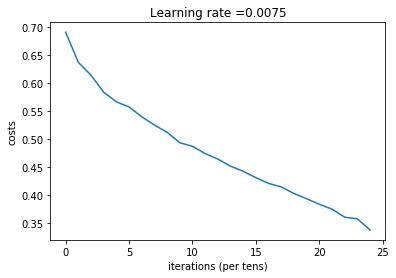

--- 840.4466769695282 seconds ---


In [24]:
start_time = tm.time()
parameters_2L = two_layer_model(x_dev, y_dev, layers_dims=(n_x, n_h, n_y), num_iterations=2500, print_cost=True)
print("--- %s seconds ---" %(tm.time()-start_time))

**Expected output**:
<table>
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.69...... </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.35...... </td>
    </tr>
</table>

#### b) L-layer model
This will take about 33mins with the dev-set on CPU.

In [25]:
### Constants ###
layers_dims = [x_dev.shape[0], 20, 7, 5, 1] # 4-layer model

Cost after iteration 0: 0.6931468489530351
Cost after iteration 100: 0.6796601550568651
Cost after iteration 200: 0.6703850880904475
Cost after iteration 300: 0.6639928324927807
Cost after iteration 400: 0.6595752553545616
Cost after iteration 500: 0.6565133468722573
Cost after iteration 600: 0.6543849316572811
Cost after iteration 700: 0.6529013970822226
Cost after iteration 800: 0.6518648026104321
Cost after iteration 900: 0.6511389131660236
Cost after iteration 1000: 0.6506296210086399
Cost after iteration 1100: 0.6502716958514385
Cost after iteration 1200: 0.6500197846998167
Cost after iteration 1300: 0.649842265776457
Cost after iteration 1400: 0.6497170367965649
Cost after iteration 1500: 0.6496286150665526
Cost after iteration 1600: 0.6495661333671889
Cost after iteration 1700: 0.6495219527711212
Cost after iteration 1800: 0.6494906949502085
Cost after iteration 1900: 0.649468569251658
Cost after iteration 2000: 0.6494529016438857
Cost after iteration 2100: 0.6494418033724013
Co

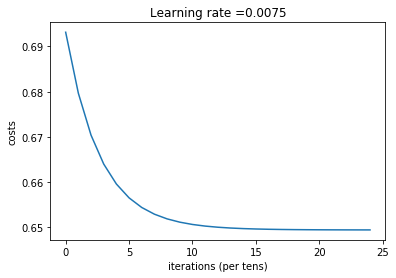

--- 969.4999940395355 seconds ---


In [26]:
start_time = tm.time()
parameters_NL = L_layer_model(x_dev, y_dev, layers_dims, num_iterations=2500, print_cost=True)
print("--- %s seconds ---" %(tm.time()-start_time))

**Expected output**:
<table>
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.69...... </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.63...... </td>
    </tr>
</table>

### 4.10 -- Calculate the accurancy of the predicting results
Predict the results and the accuracy rate.
$$\hat{Y} = A = \sigma(w^T X + b)$$

In [27]:
def predict(X, y, parameters):
    """
    Arguments:
        X -- data set of examples
        parameters -- parameters of the trained model
    
    Returns:
        p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "+str(np.sum((p==y)/m)))
    return p

In [28]:
pred_2L_dev = predict(x_dev, y_dev, parameters_2L)

Accuracy: 0.8783625730994149


In [29]:
pred_NL_dev = predict(x_dev, y_dev, parameters_NL)

Accuracy: 0.646783625730994


In [40]:
pred_2L_test_d = predict(x_test, y_test, parameters_2L)

Accuracy: 0.5878220140515221


In [41]:
pred_NL_test_d = predict(x_test, y_test, parameters_NL)

Accuracy: 0.6674473067915689


## 5 - Train the model with training data
### 5.1 2-layer model

In [32]:
### Constants ###
n_x = x_train.shape[0] # 128*128*3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

Cost after iteration 0: 0.6909930891113323
Cost after iteration 100: 0.6430108358154941
Cost after iteration 200: 0.6287651929124999
Cost after iteration 300: 0.616141111265266
Cost after iteration 400: 0.6023342806930585
Cost after iteration 500: 0.5896374107317957
Cost after iteration 600: 0.5830497351617732
Cost after iteration 700: 0.5802882199134607
Cost after iteration 800: 0.5736188027353841
Cost after iteration 900: 0.5716726761538172
Cost after iteration 1000: 0.5686340273609103
Cost after iteration 1100: 0.564369550191881
Cost after iteration 1200: 0.5610912960170513
Cost after iteration 1300: 0.5585665367058206
Cost after iteration 1400: 0.5555026386950602
Cost after iteration 1500: 0.5513599612420687
Cost after iteration 1600: 0.5482671766818983
Cost after iteration 1700: 0.5437350394668802
Cost after iteration 1800: 0.5430454198130362
Cost after iteration 1900: 0.5397497793757529
Cost after iteration 2000: 0.5372953064228024
Cost after iteration 2100: 0.5337052163587622
Co

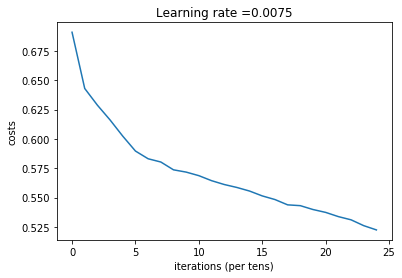

--- 2926.6498730182648 seconds ---


In [33]:
start_time = tm.time()
parameters_2L_t = two_layer_model(x_train, y_train, layers_dims=(n_x, n_h, n_y), num_iterations=2500, print_cost=True)
print("--- %s seconds ---" %(tm.time()-start_time))

### 5.2 L-layer model

In [34]:
### Constants ###
layers_dims = [x_train.shape[0], 20, 7, 5, 1] # 4-layer model

Cost after iteration 0: 0.6931473052859197
Cost after iteration 100: 0.678909143592409
Cost after iteration 200: 0.6691165966103954
Cost after iteration 300: 0.6623664851602373
Cost after iteration 400: 0.6577000560941297
Cost after iteration 500: 0.6544640720049242
Cost after iteration 600: 0.6522131915755952
Cost after iteration 700: 0.6506430520717893
Cost after iteration 800: 0.649544929411264
Cost after iteration 900: 0.6487751479122205
Cost after iteration 1000: 0.6482344363283263
Cost after iteration 1100: 0.6478539558724704
Cost after iteration 1200: 0.6475858150316712
Cost after iteration 1300: 0.647396596040251
Cost after iteration 1400: 0.6472629193292415
Cost after iteration 1500: 0.6471683904311842
Cost after iteration 1600: 0.6471014898568969
Cost after iteration 1700: 0.6470541092981629
Cost after iteration 1800: 0.6470205335179924
Cost after iteration 1900: 0.646996728453713
Cost after iteration 2000: 0.6469798436606762
Cost after iteration 2100: 0.6469678630115149
Cost

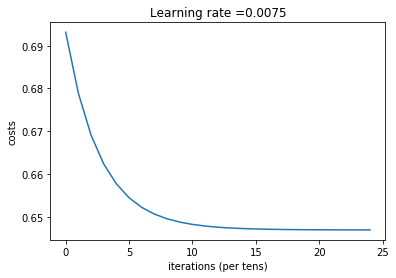

--- 3036.4761159420013 seconds ---


In [35]:
start_time = tm.time()
parameters_NL_t = L_layer_model(x_train, y_train, layers_dims, num_iterations=2500, print_cost=True)
print("--- %s seconds ---" %(tm.time()-start_time))

### 5.3 Accuracy rates

In [36]:
pred_2L_train = predict(x_train, y_train, parameters_2L_t)

Accuracy: 0.7186282151208105


In [37]:
pred_NL_train = predict(x_train, y_train, parameters_2L_t)

Accuracy: 0.7186282151208105


## 6 - Verify with testing set

In [38]:
pred_2L_test = predict(x_test, y_test, parameters_2L_t)

Accuracy: 0.6814988290398125


In [39]:
pred_NL_test = predict(x_train, y_train, parameters_2L_t)

Accuracy: 0.7186282151208105
